 This notebook is for playing around with the idea of inferring `p` in Gao type methods
from a GP posterior. We want to extend the idea to work even when we do not have
samples from a given point, e.g., the continuous context setting.

In [1]:
import torch
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import Griewank
from botorch.utils.transforms import unnormalize
from gpytorch import ExactMarginalLogLikelihood
from torch import Tensor


function = Griewank(dim=2, negate=True, noise_std=5.0)
function.bounds[0, :].fill_(-5)
function.bounds[0, :].fill_(5)


def eval_function(X: Tensor, evaluate_true: bool = False) -> Tensor:
    if evaluate_true:
        return function.evaluate_true(unnormalize(X, function.bounds))
    else:
        return function(unnormalize(X, function.bounds))

In [2]:
num_alternatives = 10

all_alternatives = torch.linspace(0, 1, num_alternatives).view(-1, 1)
sample_counts = torch.randint(4, (num_alternatives,))

train_X = all_alternatives[sample_counts]
train_Y = eval_function(train_X).view(-1, 1)

model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

In [3]:
print(f"sample_counts: {sample_counts}")
prior_var = model.forward(all_alternatives).variance
print(f"prior variance {prior_var}")
post_var = model(all_alternatives).variance
print(f"post variance {post_var}")

sample_counts: tensor([2, 1, 1, 3, 2, 0, 1, 2, 1, 2])
prior variance tensor([4.4476, 4.4476, 4.4476, 4.4476, 4.4476, 4.4476, 4.4476, 4.4476, 4.4476,
        4.4476], grad_fn=<ExpandBackward>)
post variance tensor([0.1641, 0.0453, 0.0453, 0.1641, 0.7412, 1.8111, 2.8798, 3.6359, 4.0692,
        4.2847], grad_fn=<ExpandBackward>)


What we see above suggests that it is not that straightforward. We probably need to
look closer into the covariance matrix.

# TODO: the observed noise level might be playing a part here. We should check that

In [4]:
prior_covar = model.forward(all_alternatives).covariance_matrix
print(f"prior covar {prior_covar}")
post_covar = model(all_alternatives).covariance_matrix
print(f"post covar {post_covar}")

prior covar tensor([[4.4476, 4.1209, 3.3645, 2.5117, 1.7592, 1.1755, 0.7578, 0.4750, 0.2910,
         0.1750],
        [4.1209, 4.4476, 4.1209, 3.3645, 2.5117, 1.7592, 1.1755, 0.7578, 0.4750,
         0.2910],
        [3.3645, 4.1209, 4.4476, 4.1209, 3.3645, 2.5117, 1.7592, 1.1755, 0.7578,
         0.4750],
        [2.5117, 3.3645, 4.1209, 4.4476, 4.1209, 3.3645, 2.5117, 1.7592, 1.1755,
         0.7578],
        [1.7592, 2.5117, 3.3645, 4.1209, 4.4476, 4.1209, 3.3645, 2.5117, 1.7592,
         1.1755],
        [1.1755, 1.7592, 2.5117, 3.3645, 4.1209, 4.4476, 4.1209, 3.3645, 2.5117,
         1.7592],
        [0.7578, 1.1755, 1.7592, 2.5117, 3.3645, 4.1209, 4.4476, 4.1209, 3.3645,
         2.5117],
        [0.4750, 0.7578, 1.1755, 1.7592, 2.5117, 3.3645, 4.1209, 4.4476, 4.1209,
         3.3645],
        [0.2910, 0.4750, 0.7578, 1.1755, 1.7592, 2.5117, 3.3645, 4.1209, 4.4476,
         4.1209],
        [0.1750, 0.2910, 0.4750, 0.7578, 1.1755, 1.7592, 2.5117, 3.3645, 4.1209,
         4.4476]

In certain alternatives we see significant reduction in the posterior despite
these not having any samples. We see that these alternatives have high correlation with
the other observed points, which would explain the reduction. Let's see if we can make
sense of it in some other way, e.g., taking the product of the prior with the number of
samples.

In [5]:
print(f"sample_counts: {sample_counts}")

weighted_samples =  prior_covar.matmul(sample_counts.unsqueeze(-1).to(torch.float)) / prior_covar[0, 0]

print(f"weighted samples: {weighted_samples.view(-1)}")

inferred_samples = prior_var / post_var

print(f"inferred samples: {inferred_samples.view(-1)}")

sample_counts: tensor([2, 1, 1, 3, 2, 0, 1, 2, 1, 2])
weighted samples: tensor([6.6965, 8.0214, 9.0403, 9.6266, 9.7021, 9.4068, 8.9469, 8.3305, 7.4548,
        6.2950], grad_fn=<ViewBackward>)
inferred samples: tensor([27.0953, 98.1107, 98.1107, 27.0954,  6.0001,  2.4557,  1.5444,  1.2232,
         1.0930,  1.0380], grad_fn=<ViewBackward>)


So, this doesn't really tell us much. Not sure how to proceed from here.

Let's take things to extreme and fit the GP on samples from a single point only.

In [6]:
from typing import Tuple

def single_point_gp(
    num_train: int,
    noise_level: float = 0.1,
    use_standardize: bool = True,
) -> Tuple[Tensor, Tensor]:
    X = torch.tensor([0.5]).repeat(num_train, 1)
    Y = torch.tensor([0.5]).repeat(num_train, 1) + torch.randn(num_train, 1) * noise_level
    m2 = SingleTaskGP(
        X, Y, outcome_transform=Standardize(m=1) if use_standardize else None
    )
    mll = ExactMarginalLogLikelihood(m2.likelihood, m2)
    fit_gpytorch_model(mll)
    prior_var = m2.forward(X[:1]).variance
    post_var = m2(X[:1]).variance
    return prior_var, post_var

In [7]:
prior_var, post_var = single_point_gp(10, 0.01)
print(f"prior variance {prior_var}")
print(f"post variance {post_var}")

prior variance tensor([3.4277], grad_fn=<ExpandBackward>)
post variance tensor([0.0979], grad_fn=<ExpandBackward>)


Let's see if increasing noise affects things.

In [8]:
prior_var, post_var = single_point_gp(10)
print(f"prior variance {prior_var}")
print(f"post variance {post_var}")

prior variance tensor([3.4283], grad_fn=<ExpandBackward>)
post variance tensor([0.0979], grad_fn=<ExpandBackward>)


Let's decrease / increase number of samples

In [9]:
prior_var, post_var = single_point_gp(4)
print(f"prior variance {prior_var}")
print(f"post variance {post_var}")

prior variance tensor([3.5546], grad_fn=<ExpandBackward>)
post variance tensor([0.2360], grad_fn=<ExpandBackward>)


In [10]:
prior_var, post_var = single_point_gp(40)
print(f"prior variance {prior_var}")
print(f"post variance {post_var}")

prior variance tensor([3.3545], grad_fn=<ExpandBackward>)
post variance tensor([0.0249], grad_fn=<ExpandBackward>)


Let's plot the ratio as a function of number of samples

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


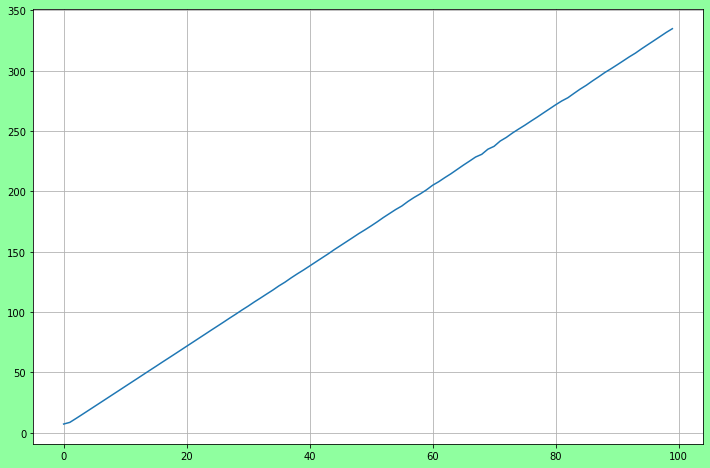

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')

ratio = torch.zeros(100)
for i in range(1, 101):
    prior_var, post_var = single_point_gp(i)
    ratio[i-1] = prior_var / post_var

plt.plot(ratio.detach())
plt.grid()
plt.show()

And without the outcome transform standardize.

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


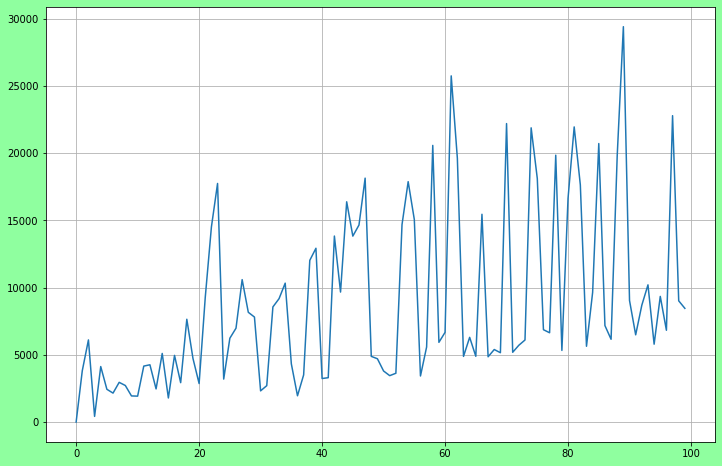

In [12]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')

ratio = torch.zeros(100)
for i in range(1, 101):
    prior_var, post_var = single_point_gp(i, use_standardize=False)
    ratio[i-1] = prior_var / post_var

plt.plot(ratio.detach())
plt.grid()
plt.show()

With Standardize, we observe a line with slope slightly larger than 3.

Without Standardize, it just goes crazy. Using Standardize here should be equivalent to
using `randn` as observations. (except for noise)

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


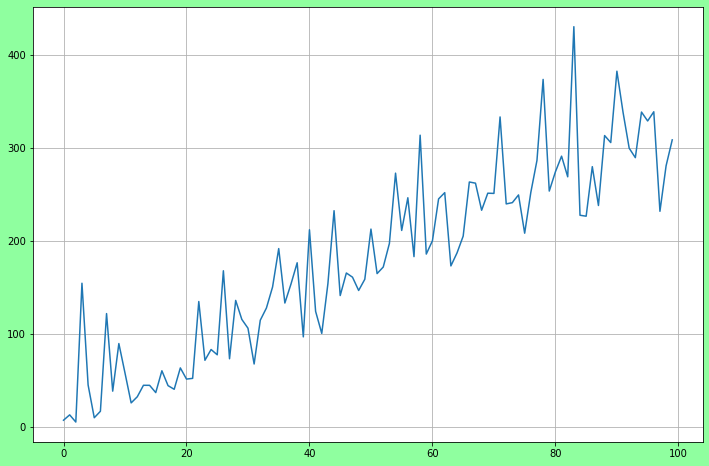

In [13]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')

ratio = torch.zeros(100)
for i in range(1, 101):
    prior_var, post_var = single_point_gp(i, 1.0, use_standardize=False)
    ratio[i-1] = prior_var / post_var

plt.plot(ratio.detach())
plt.grid()
plt.show()

Indeed, it looks like it. Standardize helps stabilize the hyper-parameters.

Let's see if we can make sense of the slope

In [14]:
X = torch.tensor([0.5]).repeat(4, 1)
Y = torch.tensor([0.5]).repeat(4, 1) + torch.randn(4, 1) * 0.1
m2 = SingleTaskGP(X, Y, outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(m2.likelihood, m2)
fit_gpytorch_model(mll)

prior_var = m2.forward(X[:1]).variance
post_var = m2(X[:1]).variance
noise = m2.likelihood.noise

In [15]:
prior_var

tensor([3.5509], grad_fn=<ExpandBackward>)

In [16]:
noise

Parameter containing:
tensor([1.0106], requires_grad=True)

In [17]:
def A_n(n: int) -> Tensor:
    return torch.ones(n, n) * prior_var + torch.eye(n) * noise

In [18]:
A_n(1).inverse()

tensor([[0.2192]], grad_fn=<InverseBackward>)

In [19]:
A_n(2).inverse()

tensor([[ 0.5564, -0.4331],
        [-0.4331,  0.5564]], grad_fn=<InverseBackward>)

In [20]:
A_n(5).inverse()

tensor([[ 0.8022, -0.1872, -0.1872, -0.1872, -0.1872],
        [-0.1872,  0.8022, -0.1872, -0.1872, -0.1872],
        [-0.1872, -0.1872,  0.8022, -0.1872, -0.1872],
        [-0.1872, -0.1872, -0.1872,  0.8022, -0.1872],
        [-0.1872, -0.1872, -0.1872, -0.1872,  0.8022]],
       grad_fn=<InverseBackward>)

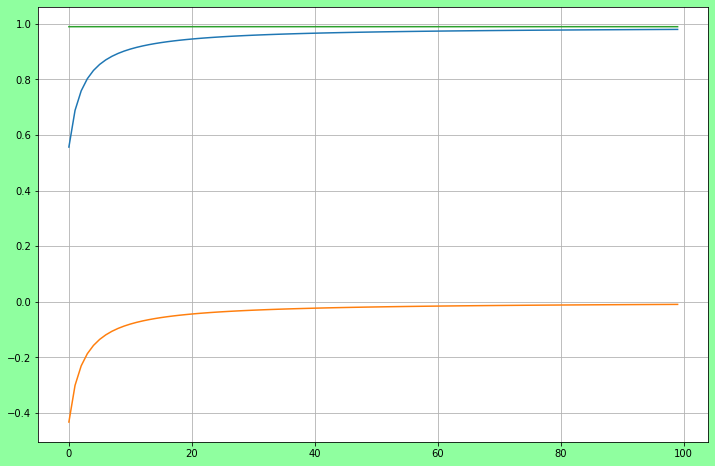

In [21]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')

diag = torch.zeros(100)
off_diag = torch.zeros(100)
for i in range(2, 102):
    A_n_inv = A_n(i).inverse()
    diag[i-2] = A_n_inv[0, 0]
    off_diag[i-2] = A_n_inv[1, 0]

plt.plot(diag.detach())
plt.plot(off_diag.detach())
plt.plot(diag.detach() - off_diag.detach())
plt.grid()
plt.show()


So, this suggests that `prior / posterior` increases linearly, which would agree with
the frequentist approaches. Just to verify this, let's go back to the original idea and
add samples to that.

In [22]:
def fit_w_repeated_inputs(num_repeats: int) -> Tuple[Tensor, Tensor]:
    X = all_alternatives[sample_counts].repeat(num_repeats, 1)
    Y = eval_function(X).view(-1, 1)

    model = SingleTaskGP(X, Y, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    _ = fit_gpytorch_model(mll)

    prior_var = model.forward(all_alternatives).variance
    post_var = model(all_alternatives).variance

    return prior_var, post_var

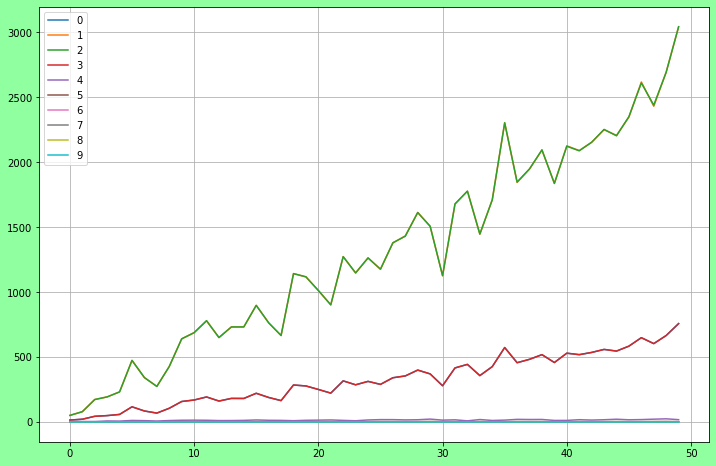

tensor([2, 1, 1, 3, 2, 0, 1, 2, 1, 2])

In [23]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')

priors = torch.zeros(50, num_alternatives)
posteriors = torch.zeros(50, num_alternatives)
for i in range(1, 51):
    prior, posterior = fit_w_repeated_inputs(i)
    priors[i-1] = prior.view(-1)
    posteriors[i-1] = posterior.view(-1)

for i in range(num_alternatives):
    plt.plot((priors[:, i] / posteriors[:, i]).detach(), label=str(i))
plt.grid()
plt.legend()
plt.show()

sample_counts

Indeed, besides the variability attributed to hyper-parameter fit, the ratio seems to
increase linearly for a given GP model.

What determines the slopes between different alternatives is still an open question
though.

When actually using this idea for the independent GP models, we will need the ratio of
samples allocated to the given points form different models. Would that scale properly
as well? Let's just test this.